# Import required packages:

In [1]:
import math
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import sys
sys.path.append('../src/gaussianProcesses')
from core import GPMarginalLogLikelihood
from kernels import SquaredExponentialKernel, Kernel

# Load data:

In [2]:
trueL = 1.0
trueSf = 1.0
trueSn = 0.1
l0 = 1.3
sf0 = 1.0
sn0 = 0.5
minimizeMethod = 'BFGS'
dataFilenamePattern = "../figScriptsRamussenAndWilliams06/ch2/results/dataFig2_5_l%.2f_sf%.2f_sn%.2f.npz"


dataFilename = dataFilenamePattern%(trueL, trueSf, trueSn)
loadRes = np.load(file=dataFilename)
x = loadRes["x"]
y = loadRes["y"]

# Choose one kernel (i.e., execute only one of the two following cells; the data was generated using MySquaredExponentialKernel, so the minimization should achieve a lower value for this kernel):

In [3]:
class MySquaredExponentialKernel(Kernel):

    def _k(self, x1, x2, params):
        l = params[0]
        s2f = params[1]**2
        s2n = params[2]**2
        answer = s2f*math.exp(-1/(2*l**2)*(x2-x1)**2)

        if x1==x2:
            answer = answer + s2n
        return answer

    def _kGrad(self, x1, x2, params):
        l = params[0]
        sf = params[1]
        sn = params[2]

        dl = sf**2/l**3*(x1-x2)**2*math.exp(-1/(2*l**2)*(x1-x2)**2)
        dsf = 2*math.exp(-1/(2*l**2)*(x1-x2)**2)*sf
        dsn = 2*(1 if x1==x2 else 0)*sn
        answer = np.array([dl, dsf, dsn])

        return(answer)

kernel = MySquaredExponentialKernel()

In [4]:
class MyPeriodicRandomFunctionKernel(Kernel):

    def _k(self, x1, x2, params):
        l = params[0]
        s2f = params[1]**2
        s2n = params[2]**2
        answer = s2f*math.exp(-(2*math.sin((x2-x1)/2)**2)/l**2)

        if x1==x2:
            answer = answer + s2n
        return answer

    def _kGrad(self, x1, x2, params):
        l = params[0]
        sf = params[1]
        sn = params[2]

        dl = sf**2*math.exp(-(2*math.sin((x2-x1)/2)**2)/l**2)*4*math.sin((x2-x1)/2)**2/l**3
        dsf = 2*sf*math.exp(-(2*math.sin((x2-x1)/2)**2)/l**2)
        dsn = 2*(1 if x1==x2 else 0)*sn
        answer = np.array([dl, dsf, dsn])

        return(answer)

kernel = MyPeriodicRandomFunctionKernel()    

# Estimate kernel parameters:

In [4]:
ml = GPMarginalLogLikelihood(x=x, y=y, kernel=kernel)
optimizationTrajectory = [np.array([l0,sf0,sn0])]

def callbackFun(xk):
    print("evaluation at (%.4f, %.4f)"%(xk[0], xk[2]))
    optimizationTrajectory.append(xk)
def evalWrapper(params, sign=1.0):
    return sign*ml.eval(params=params)
def evalGradientWrapper(params, sign=1.0):
    return sign*ml.evalGradient(params=params)
x0 = np.array([l0, sf0, sn0])
res = minimize(fun=evalWrapper, x0=x0, method=minimizeMethod,
               jac=evalGradientWrapper, args=(-1.0), 
               callback=callbackFun, options={'disp': True})

evaluation at (1.3777, -0.4726)
evaluation at (1.4220, -0.4397)
evaluation at (1.5143, -0.3573)
evaluation at (1.0543, -0.1383)
evaluation at (1.0145, -0.1273)
evaluation at (0.9992, -0.1331)
evaluation at (1.0143, -0.1316)
evaluation at (0.9786, -0.1369)
evaluation at (0.9932, -0.1355)
evaluation at (0.9934, -0.1352)
evaluation at (0.9933, -0.1352)
evaluation at (0.9933, -0.1352)
Optimization terminated successfully.
         Current function value: 9.733053
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 19


# Plot estimation results (when using MySquaredExponentialKernel the generated figure is as Fig. 5.4 from Ramussen and Williams, 2006, with the addition of the optimization path):

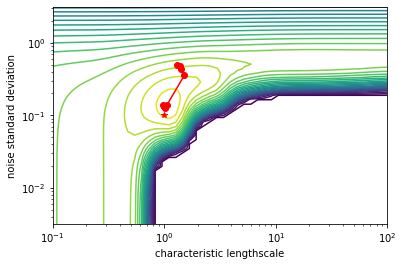

In [5]:
nSamplePointsPerAxis = 50
snStart = -2.5
snStop = 0.5
lStart = -1.0
lStop = 2.0
nLevels = 30
tooSmallThr = -60
annotateColor = 'red'
xlabel = 'characteristic lengthscale'
ylabel = 'noise standard deviation'

nSnPoints = nSamplePointsPerAxis
nLPoints = nSamplePointsPerAxis
optimizationTrajectory = np.array(optimizationTrajectory)
sns = np.logspace(start=snStart, stop=snStop, num=nSnPoints)
ls = np.logspace(start=lStart, stop=lStop, num=nLPoints)
mls = np.empty(shape=(len(sns), len(ls)))
mls[:] = np.nan
sf = trueSf

for i in range(len(sns)):
    sn = sns[i]
    for j in range(len(ls)):
        l = ls[j]
        params = np.array([l, sf, sn])
        mls[i, j] = ml.eval(params=params)
tooSmallIndices = np.where(mls<tooSmallThr)
mls[tooSmallIndices] = tooSmallThr

x = ls
y = sns
[X, Y] = np.meshgrid(x, y)
Z = mls
cp = plt.contour(X, Y, Z, nLevels)
_ = plt.plot([trueL], [trueSn], marker='*', color='red')
_ = plt.plot(abs(optimizationTrajectory[:,0]),
         abs(optimizationTrajectory[:,2]),
         color="red", marker="o", linestyle="-")
_ = plt.xscale('log')
_ = plt.yscale('log')
_ = plt.xlabel(xlabel)
_ = plt.ylabel(ylabel)